# Taller de visión por ordenador aplicado a la apicultura

## Importar librerías

In [ ]:
#!pip install -r requirements.txt

In [71]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
import cv2
%matplotlib inline

## Análisis de Imágenes

Cargamos la foto con la función de la librería de opencv. Hay que tener en cuenta que opencv trabaja en **BGR**.

In [235]:
num_foto = "3"
img = cv2.imread("fotos/"+num_foto+".jpg")

Definimos una función para mostar las imágenes.

In [236]:
def show_img(img, title='img', inline=True):
    if inline == True:
        aux = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(aux)
    else:
        cv2.imshow(title, img)
        cv2.waitKey()
        cv2.destroyAllWindows()

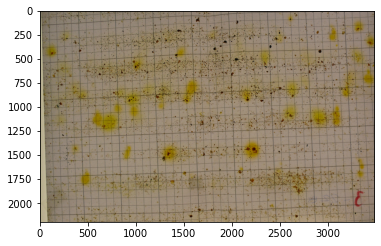

In [237]:
show_img(img)

### Procesado

#### Visualizar gráficas

In [238]:
def calcHistogram(img, canal=0):
    height = 0
    width = 0
    gray = False
    try:
        height, width, channels = img.shape
    except ValueError:
        height, width = img.shape
        gray = True
    histArray =  []
    for x in range(255):
        histArray.append(0)
    for i in range(height):
        for j in range(width):
            if gray:
                histArray[int(img.item(i,j))] += 1
            else:
                histArray[int(img.item(i,j,canal))] += 1
    return histArray

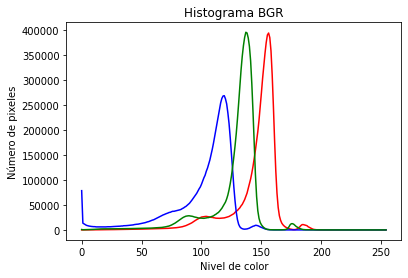

In [239]:
histRed = calcHistogram(img, 2)
plt.plot(histRed, color='red')
histBlue = calcHistogram(img, 0)
plt.plot(histBlue, color='blue')
histGreen = calcHistogram(img, 1)
plt.plot(histGreen, color='green')
plt.title("Histograma BGR")
plt.xlabel("Nivel de color")
plt.ylabel("Número de pixeles")
plt.show()

#### Extraer canal rojo

Ponemos a cero todos los canales excepto el rojo, para así resaltar los puntos mas rojizos, ya que las varroas tienen una tonalidad roja.

In [240]:
red = img.copy()
red[:,:,0] = 0
red[:,:,1] = 0

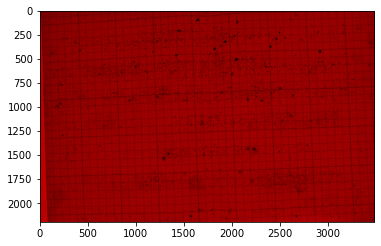

In [241]:
show_img(red)

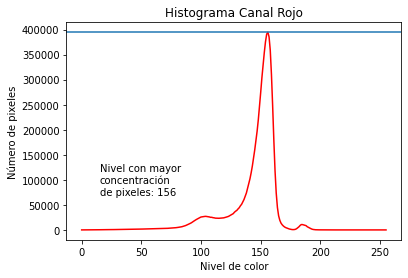

In [242]:
opencvHistRed = cv2.calcHist([img],[2], None, [256],[0,256])
plt.plot(opencvHistRed, color='red')
plt.xlabel("Nivel de color")
plt.ylabel("Número de pixeles")
plt.title("Histograma Canal Rojo")
idmax = np.argmax(opencvHistRed, axis=0)[0]
plt.text(15, 70000, "Nivel con mayor\nconcentración\nde pixeles: "+str(idmax))
plt.axhline(max(opencvHistRed))
plt.show()

In [243]:
print("Nivel con mayor concentración de pixeles: "+str(idmax))

Nivel con mayor concentración de pixeles: 156


#### Binarizar

##### Algoritmo del mínimo error de Kittler e Illingworth.

Método de umbralización de imagenes, es decir, bsuqueda del umbral óptimo que permita separar los objetos de primer plano del fondo.

<img src="imgs/formulas_1.PNG"/>
<img src="imgs/formulas_2.PNG"/>

In [244]:
def kittler(im, out):
    """Algoritmo de Mínimo Error de Kittler e Illingworth


    Arguments:
    im -- imagen en escala de grises
    out -- kernel donde estará la imagen de salida
    """

    np.seterr(divide='ignore', invalid='ignore')
    h, g = np.histogram(im.ravel(), 256, [0, 256])
    h = h.astype(np.float)
    g = g.astype(np.float)
    g = g[:-1]
    c = np.cumsum(h)
    m = np.cumsum(h * g)
    s = np.cumsum(h * g**2)
    sigma_f = np.sqrt(s/c - (m/c)**2)
    cb = c[-1] - c
    mb = m[-1] - m
    sb = s[-1] - s
    sigma_b = np.sqrt(sb/cb - (mb/cb)**2)
    p = c / c[-1]
    v = p * np.log(sigma_f) + (1-p)*np.log(sigma_b) - \
        p*np.log(p) - (1-p)*np.log(1-p)
    v[~np.isfinite(v)] = np.inf
    idx = np.argmin(v)
    t = g[idx]
    out[:, :] = 0
    out[im >= t] = 255

A partir de la imagen con el canal rojo aislado, binarizamos la imagen

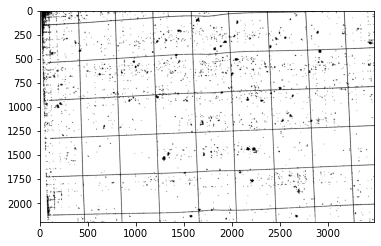

In [245]:
kernel = np.ones((5, 5), np.uint8)
dilation = cv2.dilate(red, kernel, iterations=1)
erosion = cv2.erode(dilation, kernel, iterations=1)
median = cv2.medianBlur(erosion, 3)
gray = cv2.cvtColor(erosion, cv2.COLOR_BGR2GRAY)
out = np.empty_like(gray)
kittler(gray, out)
#out = cv2.bitwise_not(out)
show_img(out)
#plt.savefig('imgs/bin.png')

#### Eliminar las lineas

##### Algoritmo Canny

In [246]:
def delete_lines(img):
    dst = cv2.Canny(img, 50, 200, None, 3)
    res = out.copy()

    linesP = cv2.HoughLinesP(dst, 1, np.pi / 180, 50, None, 50, 10)

    for i in range(0, len(linesP)):
        l = linesP[i][0]
        #cv2.line(res, (l[0], l[1]), (l[2], l[3]), (0,0,0), 10, cv2.LINE_AA)
        cv2.line(res, (l[0], l[1]), (l[2], l[3]), (255,255,255), 10, cv2.LINE_AA)
        
    return dst, res

In [247]:
cnn, res = delete_lines(out)
cnn, res = delete_lines(res)

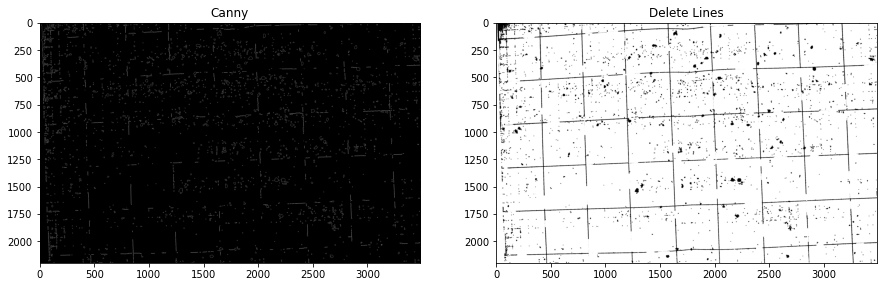

In [249]:
f = plt.figure(figsize=(15,10))
f.add_subplot(1,2, 1)
plt.title("Canny")
plt.imshow(cv2.cvtColor(cnn, cv2.COLOR_BGR2RGB))
f.add_subplot(1,2, 2)
plt.title("Delete Lines")
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.show(block=True)
f.savefig("imgs/b-a-lines.png")

#### Obtener los contornos

In [250]:
cont, jer = cv2.findContours(res, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

#### Dibujar los contornos

In [251]:
draw_org = img.copy()
_ = cv2.drawContours(draw_org, cont, -1, (0, 0, 255), 2, cv2.LINE_AA)

In [252]:
draw = res.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
_ = cv2.drawContours(draw, cont, -1, (0, 255, 0), 2, cv2.LINE_AA)

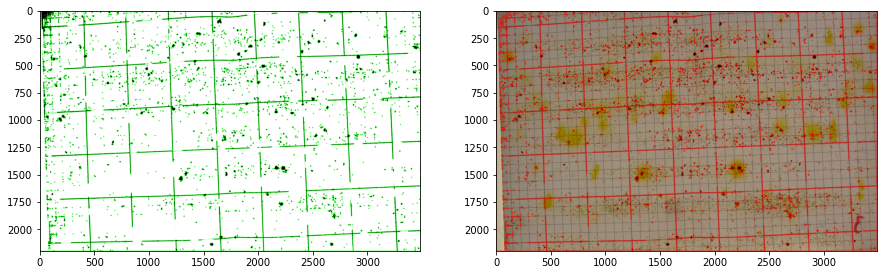

In [253]:
f = plt.figure(figsize=(15,10))
f.add_subplot(1,2, 1)
plt.imshow(cv2.cvtColor(draw, cv2.COLOR_BGR2RGB))
f.add_subplot(1,2, 2)
plt.imshow(cv2.cvtColor(draw_org, cv2.COLOR_BGR2RGB))
plt.show(block=True)
f.savefig("imgs/conts.png")

### Extracción de Caracteríasticas

#### Coordenadas

In [223]:
cont_x = []
cont_y = []

for c in cont:
    grain = np.int0(cv2.boxPoints(cv2.minAreaRect(c)))
    centroid = (grain[2][1]-(grain[2][1]-grain[0][1])//2,
                grain[2][0]-(grain[2][0]-grain[0][0])//2)
    cont_x.append(centroid[0])    
    cont_y.append(centroid[1])

#### Área

In [224]:
cont_areas = []

for c in cont:
    area = cv2.contourArea(c)
    cont_areas.append(area)

#### Excentricidad

In [225]:
cont_exc = []

pi_4 = np.pi*4

for c in cont:
    if len(c) > 5:
        area = cv2.contourArea(c)
        arclen = cv2.arcLength(c, True)
        ellipse = cv2.fitEllipse(c)# ((centroX, centroY), (semiejeMenor, semiejeMayor), anguloRotacion)
        exEl = math.sqrt(
            (ellipse[1][1]*ellipse[1][1])-(ellipse[1][0]*ellipse[1][0]))/ellipse[1][1]
        cont_exc.append(exEl)
    else:
        cont_exc.append(0)

#### Semiejes de la Elipse

In [226]:
cont_minor_axis = []
cont_major_axis = []

pi_4 = np.pi*4

for c in cont:
    if len(c) > 5:
        area = cv2.contourArea(c)
        arclen = cv2.arcLength(c, True)
        ellipse = cv2.fitEllipse(c)# ((centroX, centroY), (semiejeMenor, semiejeMayor), anguloRotacion)
        minor = ellipse[1][0]
        major = ellipse[1][1]
        cont_minor_axis.append(minor)
        cont_major_axis.append(major)
    else:
        cont_minor_axis.append(0)
        cont_major_axis.append(0)

#### Color

In [227]:
cont_red = []
cont_green = []
cont_blue = []

for c in cont:
    grain = np.int0(cv2.boxPoints(cv2.minAreaRect(c)))
    centroid = (grain[2][1]-(grain[2][1]-grain[0][1])//2,
                grain[2][0]-(grain[2][0]-grain[0][0])//2)
    color = img[centroid]
    cont_blue.append(color[0])
    cont_green.append(color[1])
    cont_red.append(color[2])

### Crear Dataset

In [228]:
data = {"x":cont_x, "y":cont_y, "area":cont_areas , "excentricidad": cont_exc, 
        "semieje_menor":cont_minor_axis, "semieje_mayor":cont_major_axis,
        "azul":cont_blue, "verde":cont_green, "rojo":cont_red}
for i in data:
    print(i + ": " + str(len(data[i])))

x: 4665
y: 4665
area: 4665
excentricidad: 4665
semieje_menor: 4665
semieje_mayor: 4665
azul: 4665
verde: 4665
rojo: 4665


In [229]:
df = pd.DataFrame(data)
df.head()

,x,y,area,excentricidad,semieje_menor,semieje_mayor,azul,verde,rojo
0,2355,2917,1.5,0.689914,4.352743,6.012978,57,77,97
1,2352,1392,0.0,0.000000,0.000000,0.000000,56,99,125
2,2116,2951,1.5,0.000000,0.000000,0.000000,70,117,127
3,2111,2947,1.0,0.000000,0.000000,0.000000,50,104,126
4,1592,22,13244.5,0.994105,47.565643,438.710876,101,119,134


In [230]:
df.describe()

,x,y,area,excentricidad,semieje_menor,semieje_mayor,azul,verde,rojo
count,4665.000000,4665.000000,4.665000e+03,4665.000000,4665.000000,4665.000000,4665.000000,4665.000000,4665.000000
mean,1049.070096,1428.719400,1.584035e+03,0.524900,9.819815,15.710295,31.193998,56.023580,74.640514
std,584.456335,827.091428,1.004018e+05,0.316213,40.573575,54.829367,27.440210,29.504206,26.768960
min,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,596.000000,683.000000,4.000000e+01,0.377964,7.384847,8.258329,5.000000,30.000000,55.000000
50%,1044.000000,1537.000000,6.100000e+01,0.595536,8.391093,11.061090,26.000000,59.000000,77.000000
75%,1433.000000,2080.000000,1.010000e+02,0.784465,9.946220,16.425476,54.000000,77.000000,93.000000
max,2355.000000,2951.000000,6.857494e+06,1.000000,2741.267578,3499.293213,117.000000,154.000000,159.000000


In [231]:
df.to_csv("datasets/image_"+num_foto+".csv")

*Realizamos el etiquitado manual*

## Análisis de los datos

### Cargamos el dataset etiquetado

In [254]:
df = pd.read_csv("datasets/image_"+num_foto+"_with_target.csv", index_col=0)

In [255]:
df.describe()

,x,y,area,excentricidad,semieje_menor,semieje_mayor,azul,verde,rojo,clase
count,2214.000000,2214.000000,2.214000e+03,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000
mean,922.659892,1529.845077,3.579976e+03,0.475342,12.013351,21.881352,31.157182,54.564137,76.261969,0.011292
std,607.851991,1042.540309,1.572981e+05,0.314121,56.476248,119.378660,31.099488,32.727347,30.595137,0.105685
min,0.000000,21.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
25%,448.250000,573.250000,3.400000e+01,0.318488,7.211102,7.723397,3.000000,25.000000,52.000000,0.000000
50%,813.000000,1538.500000,5.200000e+01,0.523804,7.993369,9.652288,19.000000,53.000000,80.000000,0.000000
75%,1425.750000,2381.500000,9.337500e+01,0.733095,9.645923,14.490713,57.750000,81.000000,99.000000,0.000000
max,2191.000000,3478.000000,7.399825e+06,0.999592,2331.480957,4536.438965,126.000000,155.000000,174.000000,1.000000


In [256]:
varroas = []
for c in cont:
    grain = np.int0(cv2.boxPoints(cv2.minAreaRect(c)))
    centroid = (grain[2][1]-(grain[2][1]-grain[0][1])//2,
                grain[2][0]-(grain[2][0]-grain[0][0])//2)
    
    if centroid[0] in df[df.clase == 1].x.values and centroid[1] in df[df.clase == 1].y.values:
        varroas.append(c)

True

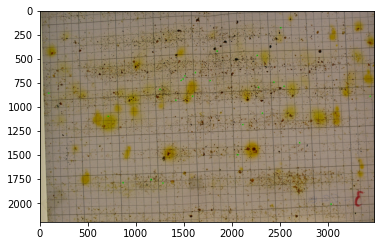

In [258]:
img = cv2.imread("fotos/"+num_foto+".jpg")
varroas_img = img.copy()
varroas_img = cv2.cvtColor(varroas_img, cv2.COLOR_BGR2RGB)
_ = cv2.drawContours(varroas_img, varroas, -1, (0, 255, 0), 2, cv2.LINE_AA)
plt.imshow(varroas_img)
cv2.imwrite("imgs/"+num_foto+"_varroas.png", cv2.cvtColor(varroas_img, cv2.COLOR_RGB2BGR))

### Gráficos

In [259]:
count = df.groupby(df.clase).count().x.values

([<matplotlib.axis.XTick at 0x1d380349940>,
 [Text(0, 0, ''), Text(0, 0, '')])

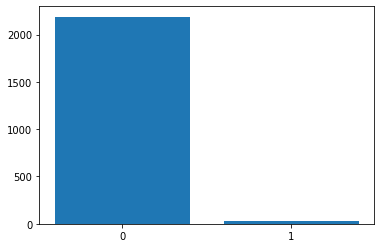

In [260]:
plt.bar([0,1], count)
plt.xticks([0,1])

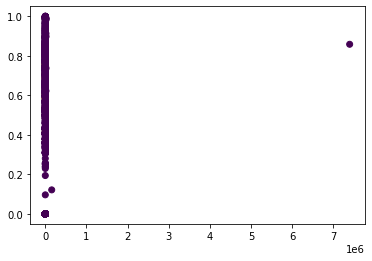

In [261]:
plt.scatter(df.area, df.excentricidad, c=df.clase)

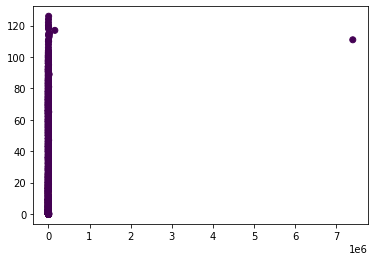

In [262]:
plt.scatter(df.area, df.azul, c=df.clase)

### SVM

In [263]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix, classification_report

In [264]:
X = df.drop(["x","y","clase"], axis=1)
y = df["clase"]

In [265]:
std = StandardScaler()
X_std = std.fit_transform(X)
X_std = pd.DataFrame(X_std, columns=X.columns)

In [266]:
X_std.head()

,area,excentricidad,semieje_menor,semieje_mayor,azul,verde,rojo
0,-0.022764,-1.513587,-0.212763,-0.183335,1.924673,1.877627,1.626051
1,-0.022764,-1.513587,-0.212763,-0.183335,0.606025,1.388629,1.168359
2,-0.022764,-1.513587,-0.212763,-0.183335,2.085483,1.999876,1.822205
3,-0.022733,1.138362,-0.144648,-0.125117,2.149808,1.999876,1.593359
4,-0.022764,-1.513587,-0.212763,-0.183335,1.796024,1.847064,1.626051


In [267]:
X_std.describe()

,area,excentricidad,semieje_menor,semieje_mayor,azul,verde,rojo
count,2.214000e+03,2.214000e+03,2.214000e+03,2.214000e+03,2.214000e+03,2.214000e+03,2.214000e+03
mean,-3.209317e-18,-4.813975e-17,1.123261e-17,-1.444193e-17,-8.986087e-17,-1.283727e-17,-1.283727e-17
std,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00
min,-2.276432e-02,-1.513587e+00,-2.127632e-01,-1.833351e-01,-1.002081e+00,-1.667610e+00,-2.395104e+00
25%,-2.254813e-02,-4.994553e-01,-8.505050e-02,-1.186238e-01,-9.055950e-01,-9.035507e-01,-7.931800e-01
50%,-2.243367e-02,1.543116e-01,-7.119613e-02,-1.024624e-01,-3.910009e-01,-4.780377e-02,1.222049e-01
75%,-2.217057e-02,8.207386e-01,-4.192847e-02,-6.192320e-02,8.552818e-01,8.079431e-01,7.433589e-01
max,4.703119e+01,1.669320e+00,4.107907e+01,3.782567e+01,3.050347e+00,3.069560e+00,3.195283e+00


In [268]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=30)

In [269]:
svc = SVC(class_weight="balanced")
svc.fit(X_train, y_train)

SVC(class_weight='balanced')

In [270]:
svc.score(X_test,y_test)

0.7358916478555305

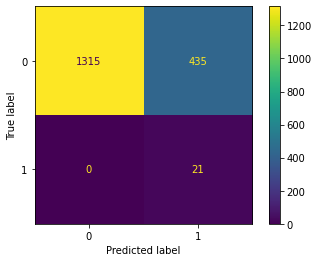

In [271]:
plot_confusion_matrix(svc, X_train, y_train)

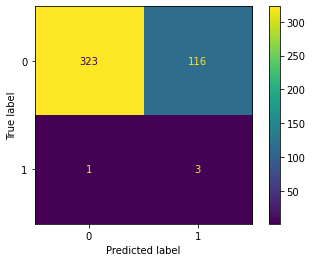

In [272]:
plot_confusion_matrix(svc, X_test, y_test)

In [273]:
classification_report(y_test, svc.predict(X_test))

'              precision    recall  f1-score   support\n\n           0       1.00      0.74      0.85       439\n           1       0.03      0.75      0.05         4\n\n    accuracy                           0.74       443\n   macro avg       0.51      0.74      0.45       443\nweighted avg       0.99      0.74      0.84       443\n'

### Random Forest

In [274]:
from sklearn.ensemble import RandomForestClassifier

In [275]:
clf = RandomForestClassifier(max_depth=2, random_state=0, class_weight="balanced")

In [276]:
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=2, random_state=0)

In [277]:
clf.score(X_test,y_test)

0.9435665914221218

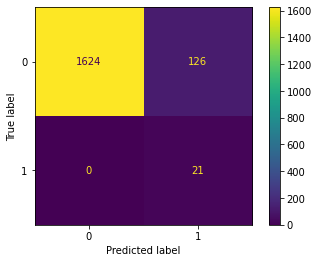

In [278]:
plot_confusion_matrix(clf, X_train, y_train)

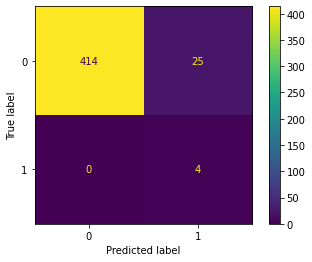

In [279]:
plot_confusion_matrix(clf, X_test, y_test)

In [280]:
classification_report(y_test, clf.predict(X_test))

'              precision    recall  f1-score   support\n\n           0       1.00      0.94      0.97       439\n           1       0.14      1.00      0.24         4\n\n    accuracy                           0.94       443\n   macro avg       0.57      0.97      0.61       443\nweighted avg       0.99      0.94      0.96       443\n'

### XGBoost

In [281]:
import xgboost as xgb

In [282]:
xgbcl = xgb.XGBClassifier()
xgbcl.fit(X_train, y_train)

[21:19:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\juanl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [283]:
xgbcl.score(X_test, y_test)

0.9932279909706546

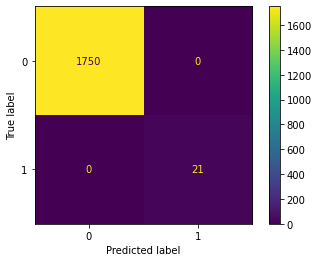

In [284]:
plot_confusion_matrix(xgbcl, X_train, y_train)

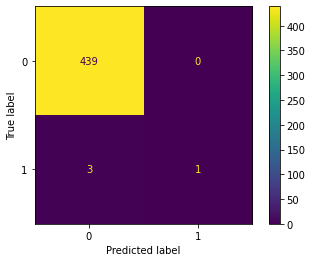

In [285]:
plot_confusion_matrix(xgbcl, X_test, y_test)

In [286]:
classification_report(y_train, xgbcl.predict(X_train))

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00      1750\n           1       1.00      1.00      1.00        21\n\n    accuracy                           1.00      1771\n   macro avg       1.00      1.00      1.00      1771\nweighted avg       1.00      1.00      1.00      1771\n'

### Neural Network

In [287]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [288]:
from keras.models import Sequential
from keras.layers import Dense

In [289]:
nn = Sequential()
nn.add(Dense(512, input_dim=7, activation='relu'))
nn.add(Dense(7, activation='relu'))
nn.add(Dense(1, activation='sigmoid'))

In [290]:
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC()])

In [291]:
nn.fit(X_train, y_train, epochs=150, batch_size=10)

Epoch 1/150
178/178 [==============================] - 3s 6ms/step - loss: 0.2523 - auc: 0.4451A: 0s - loss: 0.2818 - auc: 0
Epoch 2/150
178/178 [==============================] - 1s 6ms/step - loss: 0.0495 - auc: 0.8074A: 0s - loss: 0.0494
Epoch 3/150
178/178 [==============================] - 1s 6ms/step - loss: 0.0564 - auc: 0.8679
Epoch 4/150
178/178 [==============================] - 1s 6ms/step - loss: 0.0494 - auc: 0.9057
Epoch 5/150
178/178 [==============================] - 1s 6ms/step - loss: 0.0535 - auc: 0.9027
Epoch 6/150
178/178 [==============================] - 1s 6ms/step - loss: 0.0568 - auc: 0.8707
Epoch 7/150
178/178 [==============================] - ETA: 0s - loss: 0.0507 - auc: 0.8559    - ETA: 1s - loss: 0.01 - 1s 6ms/step - loss: 0.0505 - auc: 0.8585
Epoch 8/150
178/178 [==============================] - 1s 6ms/step - loss: 0.0483 - auc: 0.8833
Epoch 9/150
178/178 [==============================] - 1s 7ms/step - loss: 0.0419 - auc: 0.9107A: 0s - loss: 0.0400 - 

178/178 [==============================] - 1s 6ms/step - loss: 0.0249 - auc: 0.9591
Epoch 82/150
178/178 [==============================] - 1s 6ms/step - loss: 0.0243 - auc: 0.9402
Epoch 83/150
178/178 [==============================] - 1s 6ms/step - loss: 0.0268 - auc: 0.9914
Epoch 84/150
178/178 [==============================] - 1s 6ms/step - loss: 0.0252 - auc: 0.9843
Epoch 85/150
178/178 [==============================] - 1s 6ms/step - loss: 0.0282 - auc: 0.9786
Epoch 86/150
178/178 [==============================] - 1s 6ms/step - loss: 0.0220 - auc: 0.9147
Epoch 87/150
178/178 [==============================] - 1s 6ms/step - loss: 0.0174 - auc: 0.9101
Epoch 88/150
178/178 [==============================] - 1s 6ms/step - loss: 0.0186 - auc: 0.9742
Epoch 89/150
178/178 [==============================] - 1s 6ms/step - loss: 0.0276 - auc: 0.9317
Epoch 90/150
178/178 [==============================] - 1s 6ms/step - loss: 0.0209 - auc: 0.9619
Epoch 91/150
178/178 [=====================

In [292]:
nn.evaluate(X_test, y_test)

14/14 [==============================] - 0s 4ms/step - loss: 0.0615 - auc: 0.8602


[0.06152733787894249, 0.8601936101913452]